We set the required confidence to draw any conclusions from any of the statistical tests (t-test, ANOVA) at 95%.

In [388]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from sklearn import linear_model

from scipy import stats

In [282]:
df = pd.read_csv("wine.csv")
df.dtypes

wine           object
winery         object
category       object
designation    object
varietal       object
appellation    object
alcohol        object
price          object
rating          int64
reviewer       object
review         object
dtype: object

When reading a CSV-file, Pandas attempts to convert all numeric columns to the proper datatype. Whenever these are not formatted in a way Pandas is sure to correctly interpret, they are left as Strings. Some data-engineering in this regard is required, because not all columns have been interpreted as one would expect them to be. We'll start out with that.

<h2>DataType-Engineering</h2>

<h3>Numeric columns</h3>

Out of the columns expected to be numeric (alcohol, price and rating), only rating has been correctly identified as numeric. We'll examine what the values look like to get a better understanding of the required operations.

In [283]:
numeric_columns = ["alcohol", "price", "rating"]

In [284]:
df[numeric_columns].head(10)

,alcohol,price,rating
0,NaN,$32,87
1,15%,$17,85
2,NaN,NaN,90
3,13.5%,$18,86
4,13.5%,$21,85
5,15.1%,$40,89
6,15.1%,$60,92
7,12%,$19,88
8,13%,$16,87
9,13.5%,$30,89


Rating has already been identified correctly as Integer. We'll work through the other 2, one at a time, to fix them as well.

<h4>Alcohol</h4>

Alcohol has some NaN values where the data is missing in the dataset. Besides those, everything is formatted as a floating-point number with '%' as suffix. We can fix this by applying a simple string-formatting function to the entire columns, and then converting to floating points numbers. Before doing this however, we'll note how many missing values there are, to make sure we don't accidentally lose more data through wrong assumptions about string formatting. These missing values are interpreted as the float datatype, which we should make sure not to affect with our string formatting function.

In [285]:
f"There are {df['alcohol'].isna().sum()} missing values in the alcohol column."

'There are 41021 missing values in the alcohol column.'

In [286]:
df["new alcohol"] = df["alcohol"].map(
    lambda string: string.strip("%"),
    na_action="ignore"
)

df["new alcohol"] = pd.to_numeric(df["new alcohol"])

In [287]:
f"There are {df['new alcohol'].isna().sum()} missing values in the new alcohol column."

'There are 41021 missing values in the new alcohol column.'

The same amount of values remain, and we've successfully converted the column to floating-point numbers. We'll overwrite the old alcohol column, and drop the new one, so we can move on to the next column.

In [288]:
df["alcohol"] = df["new alcohol"]
df.drop(columns="new alcohol", inplace=True)

<h4>Price</h4>

From our initial look at a subset of values in the numeric columns, it appears the steps that need to be taken to correct the datatype of the price column are similar to the steps we took with the alcohol column. This time, we have a '$' prefix instead.

In [289]:
f"There are {df['price'].isna().sum()} missing values in the price column."

'There are 23955 missing values in the price column.'

In [290]:
df["new price"] = df["price"].map(
    lambda string: string.strip("$"),
    na_action="ignore"
)

df["new price"] = pd.to_numeric(df["new price"], errors="coerce")

In [291]:
f"There are {df['new price'].isna().sum()} missing values in the new price column."

'There are 31199 missing values in the new price column.'

It appears we did lose some data in this conversion. Considering there are 300.000+ records in the dataset, this reduction of sample-size is not catastrophic. Still, let's see if we can get some insight into the lost values. To do this, we'll view a subset of the dataset where values are NaN in the new column, but where not NaN in the old column.

In [292]:
price_not_formatted = df[df["new price"].isna() & df["price"].notna()]

In [293]:
price_not_formatted["price"].value_counts()

VivinoGary's Wine                            3024
VivinoWine.com                               1586
DrizlyVivino                                 1165
VivinoWine Express                            280
VivinoGary's WineTotal Wine                   204
                                             ... 
DrizlyGary's WineVivino                         1
VivinoGary's WineTotal WineWine.com             1
Wine.comVivinoGary's Wine                       1
VivinoWine.comGary's Wine                       1
VivinoGary's WineTotal WineWired for Wine       1
Name: price, Length: 83, dtype: int64

These are clearly not useful prices, that could ever be converted to prices. We can replace the old price column with the new one, drop the new one, and drop mark the dataframe we just created for garbage collection.

In [294]:
df["price"] = df["new price"]
df.drop(columns="new price", inplace=True)
price_not_formatted = None  # Make DataFrame go out of scope, so that garbage collector cleans it up.

We have corrected the incorrect Data Types in the numeric columns, so now we can move on to the other columns.

<h3>Categorical Variables</h3>

Some of the categorical variables need some work as well. We'll print out the data once more to gain some insight.

In [295]:
df.head(5)

,wine,winery,category,designation,varietal,appellation,alcohol,price,rating,reviewer,review
0,J. Lohr 2000 Hilltop Vineyard Cabernet Sauvign...,J. Lohr,Red,Hilltop Vineyard,Cabernet Sauvignon,"Paso Robles, Central Coast, California, US",NaN,32.0,87,NaN,"Held back nearly five years, this Cab still ha..."
1,Antucura 2010 Pinot Noir (Vista Flores),Antucura,Red,NaN,Pinot Noir,"Vista Flores, Mendoza Province, Argentina",15.0,17.0,85,Michael Schachner,"Rubbery, bold and earthy on the nose, then ful..."
2,Quinta do Portal 1999 Quinta do Portal Reserva...,Quinta do Portal,Red,Quinta do Portal Reserva,"Red Blends, Red Blends","Douro, Portugal",NaN,NaN,90,Roger Voss,"Smoky, meaty aromas lead into perfumed fruit f..."
3,Tenuta di Ghizzano 2006 Il Ghizzano Red (Toscana),Tenuta di Ghizzano,Red,Il Ghizzano,"Red Blends, Red Blends","Toscana, Tuscany, Italy",13.5,18.0,86,NaN,The nose is rather neutral save for distant ar...
4,Tenuta San Francesco 2007 Tramonti White (Camp...,Tenuta San Francesco,White,Tramonti,White Blend,"Campania, Southern Italy, Italy",13.5,21.0,85,NaN,"This intriguing blend of Falanghina, Biancolel..."


There are some variables that are absolutely not useful in any way for the questions we're trying to answer, like the review text, and the wine's title. We can safely remove these from the dataset.

In [296]:
df.drop(
    columns=["wine", "review"],
    inplace=True
)

The other columns can be interpreted as categorical variables. To improve readability, we can mark these columns as categories.

In [297]:
categorical_columns = ["winery", "category", "designation", "varietal", "appellation", "reviewer"]

In [298]:
df[categorical_columns] = df[categorical_columns].astype("category")
df.dtypes

winery         category
category       category
designation    category
varietal       category
appellation    category
alcohol         float64
price           float64
rating            int64
reviewer       category
dtype: object

That's all the datatypes taken care of.

<h2>Outliers</h2>

The numerical columns could very well contain outliers. We can get a sense of these through boxplots.



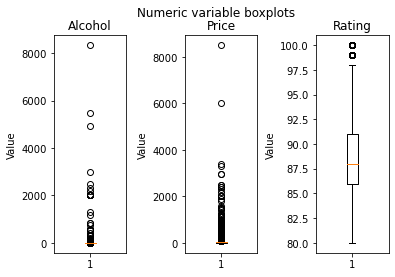

In [299]:
fig = plt.figure()
fig.subplots_adjust(wspace=.8)
fig.suptitle("Numeric variable boxplots")

for i, col in enumerate(numeric_columns):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.boxplot(df.loc[df[col].notna(), col])
    ax.set_ylabel("Value")
    ax.set_title(col.capitalize())



Alcohol and price appear to have some significant outliers. We can take care of those individually.

<h4>Alcohol</h4>

It's a fact of nature that a liquid can't have an alcohol percentage higher then 100%. We can go even lower by specifying our definition of wine. In the Netherlands, the highest permitted alcohol percentage for wine is set at 18.0%, with a lower limit for some categories. We'll remove any wines that violate that constraint.

The mininum amount of alcohol that a wine should have, to be called a wine in the Netherlands, is 1.2%. We can also remove any wines that violate that law.

https://www.belastingdienst.nl/bibliotheek/handboeken/html/boeken/HA/wijn-alcoholpercentage_volume_en_verrijking.html
#TODO(m-jeu): Referenties ofzo lol

In [300]:
df["alcohol"] = df.loc[((df["alcohol"] <= 18) & (df["alcohol"] >= 1.2)), "alcohol"]


<h4>Price</h4>

As one might expect, even though the bulk of wine seems to be in the price range of what most consumers would consider 'reasonable', there are some very expensive exceptions. We're interested most in the types of wines that a more average consumer would consume on a more regular basis, then in wines that would be considered 'luxury'. It's hard to base a limit of what to exclude on non-statistical information, considering what a person considers luxury is very much a cultural and personal thing. Therefore, we'll set the limit of what to exclude as at least 3 inter-quartile ranges away from both q1 and q3, considering this is a universally accepted definition of 'extreme outliers'. #TODO(m-jeu): Bron.

In [301]:
q1 = df["price"].quantile(.25)
q3 = df["price"].quantile(.75)

iqr3 = (q3 - q1) * 3
df["price"] = df.loc[
    ((df["price"] < q3 + iqr3) & (df["price"] > q1 - iqr3)),
    "price"
]

We've remove the outliers, now we can move on.

<h2>Distributions</h2>

Having removed the outliers, we can have a look at the exact distributions through histograms.

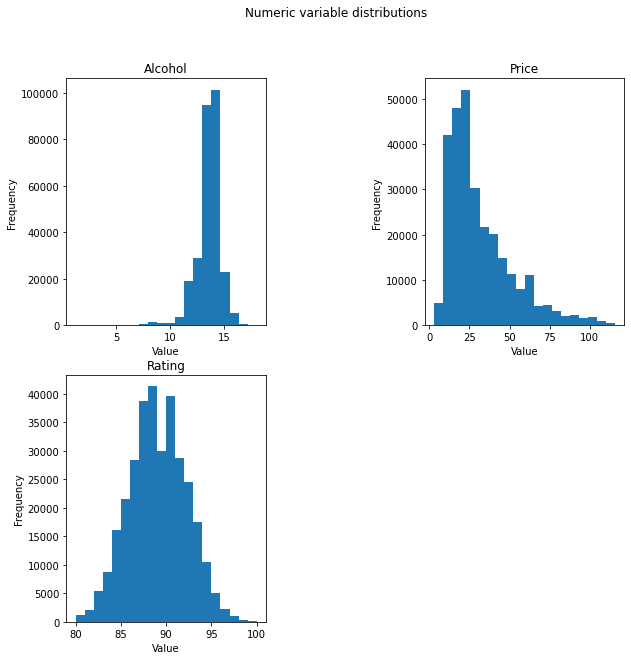

In [302]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(wspace=.8)
fig.suptitle("Numeric variable distributions")

for i, col in enumerate(numeric_columns):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.hist(df.loc[df[col].notna(), col], bins=20)
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Value")
    ax.set_title(col.capitalize())


Rating appears normally distributed. Price appears to be log normally distributed, but would require further testing. Alcohol's distribution is hard to gauge, because we permitted outliers far from the centre to remain in the sample. We can zoom in, to allow us to see the distribution more clearly.

Text(0.5, 1.0, 'Frequency of alcohol measurements, zoomed in to centre of distribution')

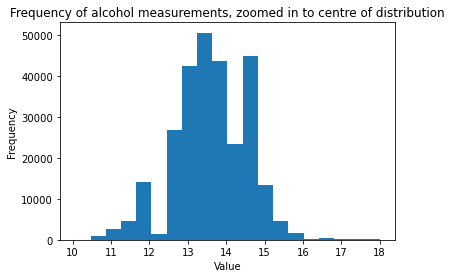

In [335]:
plt.hist(df.loc[df["alcohol"] > 10, "alcohol"], bins=20)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Frequency of alcohol measurements, zoomed in to centre of distribution")

Alcohol percentage also appears like it potentially could be normally distributed, but requires more looking into as well.

TODO(m-jeu): Normality tests?

<h2>Hypotheses and tests</h2>

Having engineered and examined in a more general sense, we can start working towards the specific hypotheses and tests.

<h3>ANOVA: Wine Categories.</h3>

In [336]:
df["category"].value_counts()

Red            194396
White           95424
Sparkling       14938
Rose            11667
Dessert          4329
Port/Sherry      2257
Fortified         226
Name: category, dtype: int64

We'll leave Port/Sherry out of scope, because parts of those are categories that already lost quite some wines by excluding based on alcohol percentage. We'll also exclude dessert wine, because the line between dessert wine and other types of wine is less distinct then between some of the categories that remain.

In [358]:
# For aesthetic purposes:
color_dict = {
    "Red": "red",
    "White": "yellow",
    "Sparkling": "chartreuse",
    "Rose": "lavenderblush"
}

In [360]:
anova_cats = color_dict.keys()

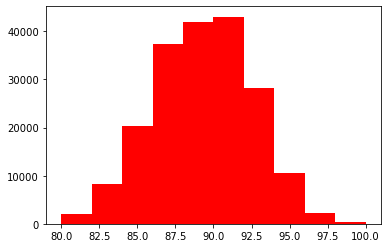

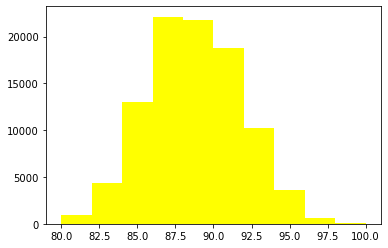

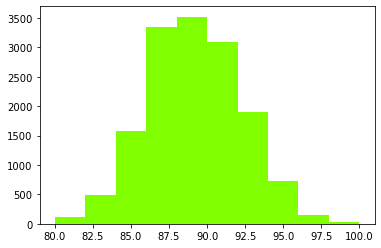

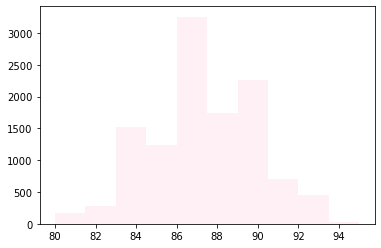

In [361]:
for cat in anova_cats:
    plt.hist(df.loc[df["category"] == cat, "rating"], color=color_dict[cat])
    plt.show()

All categories appear approximately normally distributed. We can apply ANOVA, to these 4 categories to see whether there are significant statistical differences between them.

In [369]:
anova_data = [df.loc[df["category"] == cat, "rating"] for cat in anova_cats]

f_stat, p_anova = stats.f_oneway(anova_data[0], anova_data[1], anova_data[2], anova_data[3])

In [370]:
f_stat

1590.528595614146

In [371]:
p_anova

0.0

In [366]:
for l in anova_data:
    print(np.average(l))

88.80213070227782
88.21433811200536
88.67358414781096
87.11528242050227


Very significant, not very big difference?

<h2>T-test</h2>

Between different grapes?


In [372]:
df["varietal"].value_counts()

Pinot Noir                        33523
Chardonnay                        29439
Cabernet Sauvignon                23829
Red Blends, Red Blends            20012
Bordeaux-style Red Blend          17861
                                  ...  
Irsai Oliver, Other White             1
Cayuga White, Other White             1
Sideritis, Greek White                1
Silvaner-Traminer, White Blend        1
Karalahna, Other Red                  1
Name: varietal, Length: 869, dtype: int64

Sauvignon blanc Chardonnay

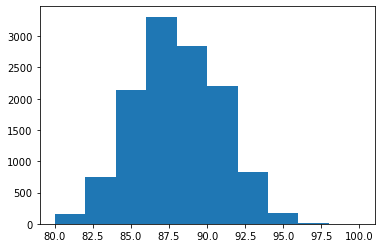

87.48776561493882


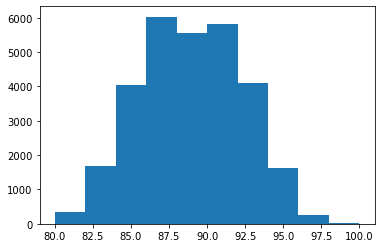

88.43279323346582


In [377]:
tcats = ["Sauvignon Blanc", "Chardonnay"]

for cat in tcats:
    plt.hist(df.loc[df["varietal"] == cat, "rating"])
    plt.show()
    print(np.average(df.loc[df["varietal"] == cat, "rating"]))

In [378]:
stats.ttest_ind(df.loc[df["varietal"] == tcats[0], "rating"], df.loc[df["varietal"] == tcats[1], "rating"])

Ttest_indResult(statistic=-27.58980780866051, pvalue=4.5441493446522265e-166)

Small difference, big significane.

<h2>Linreg + pearson</h2>

Alcohol + price = rating?

In [382]:
df[numeric_columns].corr()["rating"]

alcohol    0.154296
price      0.554115
rating     1.000000
Name: rating, dtype: float64

Price correlates to rating medium, alcohol weak.

Linreg price -> rating.

In [396]:
df_numeric = df[numeric_columns].dropna()

In [397]:
price_transformed = df_numeric["price"].to_numpy().reshape((-1, 1))

In [399]:
model_2d = linear_model.LinearRegression()
model_2d.fit(price_transformed, df_numeric["rating"])
model_2d.score(price_transformed, df_numeric["rating"])

0.3096350837027201

Can we make better?

In [401]:
model_3d = linear_model.LinearRegression()
model_3d.fit(df_numeric[["price", "alcohol"]], df_numeric["rating"])
model_3d.score(df_numeric[["price", "alcohol"]], df_numeric["rating"])

0.30964252431425054

Not really